In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [149]:
import warnings
warnings.filterwarnings("ignore")

In [150]:
df=pd.read_csv('cars.csv')
df.head()

,Car_ID,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5,800000
1,2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5,1000000
2,3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4,2500000
3,4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5,600000
4,5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5,850000


In [151]:
df=df.drop('Car_ID',axis=1)

In [152]:
df=pd.get_dummies(df,columns=['Brand','Model','Year','Fuel_Type','Transmission','Owner_Type'],dtype=int)
df.head()

,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Brand_Audi,Brand_BMW,Brand_Ford,Brand_Honda,...,Year_2019,Year_2020,Year_2021,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Second,Owner_Type_Third
0,50000,15,1498,108,5,800000,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,40000,17,1597,140,5,1000000,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
2,20000,10,4951,395,4,2500000,0,0,1,0,...,0,0,0,0,1,1,0,1,0,0
3,30000,23,1248,74,5,600000,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
4,60000,18,1999,194,5,850000,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [153]:
X=df.drop('Price',axis=1)
y=df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

scaler_y=StandardScaler()
y_train=scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [154]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.FloatTensor(y_train)
y_test=torch.FloatTensor(y_test)

In [155]:
train_ds=TensorDataset(X_train,y_train)
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)

test_ds=TensorDataset(X_test,y_test)
test_dl=DataLoader(test_ds,batch_size=32,shuffle=False)

In [1]:
from TorchIt import TabularData as td

In [2]:
class Model(td.TabularModel):

    def __init__(self,in_size:int,layers:list,out_size:int,p=0.5):
        super().__init__()
        all_layers=[]
        for i in layers:
            all_layers.append(nn.Linear(in_size,i))
            all_layers.append(nn.ReLU())
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            in_size=i
        all_layers.append(nn.Linear(layers[-1],out_size))
        self.layers=nn.Sequential(*all_layers)
    
    def forward(self,X):
        return self.layers(X)

In [158]:
model=Model(X_train.shape[1],[128,64,32],1,0.2)
model

Model(
  (layers): Sequential(
    (0): Linear(in_features=87, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [159]:
lr=0.001
epochs=20

In [160]:
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [161]:
model.compile(loss_fn=loss_fn,
              optimizer=optimizer,
              task='regression')

In [162]:
history=model.fit(epochs=epochs,
                  train_loader=train_dl,
                  val_loader=test_dl)

Training on cpu
Epoch [1], train_loss: 1.2970, val_loss: 0.7807, val_mse: 0.7890
Epoch [2], train_loss: 1.0755, val_loss: 0.7604, val_mse: 0.7317
Epoch [3], train_loss: 0.6752, val_loss: 0.7568, val_mse: 0.6683
Epoch [4], train_loss: 0.5223, val_loss: 0.7692, val_mse: 0.5927
Epoch [5], train_loss: 0.4346, val_loss: 0.7849, val_mse: 0.5011
Epoch [6], train_loss: 0.2729, val_loss: 0.8224, val_mse: 0.4092
Epoch [7], train_loss: 0.3350, val_loss: 0.8722, val_mse: 0.3348
Epoch [8], train_loss: 0.3054, val_loss: 0.9312, val_mse: 0.2630
Epoch [9], train_loss: 0.2209, val_loss: 0.9875, val_mse: 0.2001
Epoch [10], train_loss: 0.2154, val_loss: 1.0367, val_mse: 0.1581
Epoch [11], train_loss: 0.3312, val_loss: 1.1007, val_mse: 0.1304
Epoch [12], train_loss: 0.2452, val_loss: 1.1344, val_mse: 0.1087
Epoch [13], train_loss: 0.1472, val_loss: 1.1935, val_mse: 0.0945
Epoch [14], train_loss: 0.1812, val_loss: 1.2369, val_mse: 0.0850
Epoch [15], train_loss: 0.1363, val_loss: 1.2244, val_mse: 0.0808
Epo

In [163]:
model.metrics(test_ds)

(0.062818274, 0.25063574, 0.1900076, 0.9116217494010925)

In [169]:
import torch
import pandas as pd

def make_df_pytorch(model, test_dl, scaler_y):
    model.eval()  
    actuals = []
    predictions = []
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dl:
            pred = model(X_batch)
            pred = pred.cpu().numpy() 
            y_batch = y_batch.cpu().numpy()
            
           
            y_actual_inv = scaler_y.inverse_transform(y_batch.reshape(-1, 1)).ravel()
            pred_inv = scaler_y.inverse_transform(pred.reshape(-1, 1)).ravel()
            
            actuals.extend(y_actual_inv)
            predictions.extend(pred_inv)
    
    return pd.DataFrame({'Actual': actuals, 'Predicted': predictions})

In [170]:
test_df=make_df_pytorch(model,test_dl,scaler_y)
test_df['Predicted']=test_df['Predicted'].round(0)

In [171]:
test_df.head()

,Actual,Predicted
0,1800000.0,1456845.0
1,1000000.0,1361186.0
2,700000.0,905181.0
3,2500000.0,2424422.0
4,550000.0,939338.0


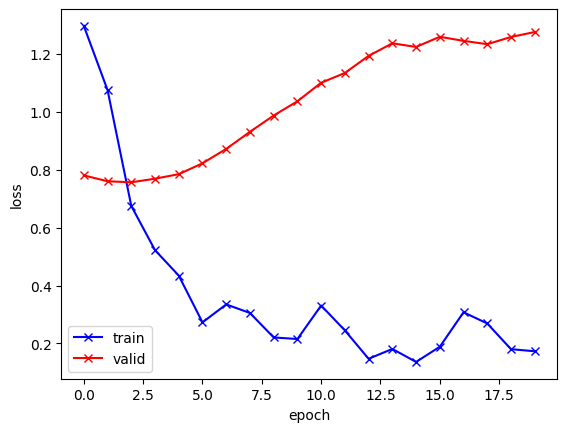

In [167]:
model.plot_losses()

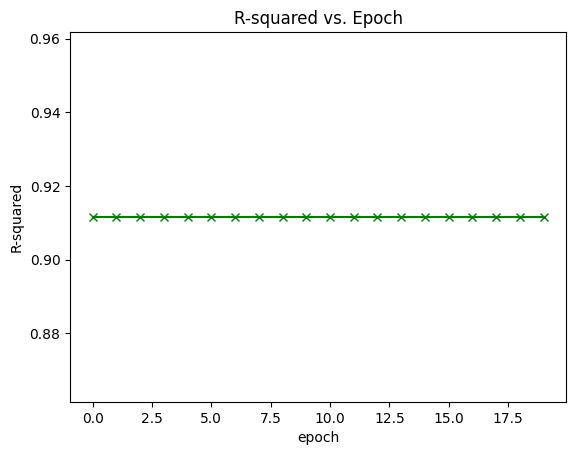

In [168]:
model.plot_r2(test_ds)